In [1]:
df = pd.read_fwf('data/headlines.txt')
df.columns = ['headline']
df.head()

,headline
0,Could Zika Reach New York City?
1,First Case of Zika in Miami Beach
2,"Mystery Virus Spreads in Recife, Brazil"
3,Dallas man comes down with case of Zika
4,Trinidad confirms first Zika case


In [2]:
import geonamescache

gc = geonamescache.GeonamesCache()
countries = gc.get_countries()
cities = gc.get_cities()

country_names = []
country_ids = list(countries.keys())
for country_id in country_ids:
    country_names.append(countries[country_id]['name'])
    
city_names = []
city_ids = list(cities.keys())
for city_id in city_ids:
    city_names.append(cities[city_id]['name'])

In [3]:
len(country_names), len(city_names)

(252, 24336)

In [4]:
from collections import Counter

country_counts = Counter(country_names)
country_counts.most_common(10)

[('Andorra', 1),
 ('United Arab Emirates', 1),
 ('Afghanistan', 1),
 ('Antigua and Barbuda', 1),
 ('Anguilla', 1),
 ('Albania', 1),
 ('Armenia', 1),
 ('Angola', 1),
 ('Antarctica', 1),
 ('Argentina', 1)]

In [5]:
city_counts = Counter(city_names)
city_counts.most_common(10)

[('Springfield', 8),
 ('San Pedro', 7),
 ('Richmond', 7),
 ('San Fernando', 7),
 ('Mercedes', 6),
 ('La Paz', 6),
 ('Victoria', 6),
 ('San Francisco', 6),
 ('Auburn', 6),
 ('Santa Cruz', 6)]

There is no duplicate country names in the data, but many duplicate city names.

### Removing Accent Marks

In [6]:
from unidecode import unidecode

country_accent_mapping = {
    unidecode(country): country for country in country_names
}

city_accent_mapping = {
    unidecode(city): city for city in city_names
}

In [7]:
city_accent_mapping['Neuquen']

'Neuquén'

In [8]:
# Remove accent marks in the data too
df['headline'] = df['headline'].apply(unidecode)

In [9]:
unaccented_countries = list(country_accent_mapping.keys())
unaccented_cities = list(city_accent_mapping.keys())

print(f"There are {len(unaccented_countries)} countries to look from.")
print(f"There are {len(unaccented_cities)} cities to look from.")

There are 252 countries to look from.
There are 23022 cities to look from.


In [10]:
import re

problem_city = 'San Diego'
re.search('\\bSan\\b|\\bSan Diego\\b', problem_city)

<_sre.SRE_Match object; span=(0, 3), match='San'>

In [11]:
re.search('\\bSan Diego\\b|\\bSan\\b', problem_city)

<_sre.SRE_Match object; span=(0, 9), match='San Diego'>

### Sort Cities and Countries by Length

In [12]:
unaccented_countries = sorted(unaccented_countries, key=lambda x: len(x), reverse=True)
unaccented_cities = sorted(unaccented_cities, key=lambda x: len(x), reverse=True)

In [13]:
unaccented_countries[:5]

['South Georgia and the South Sandwich Islands',
 'United States Minor Outlying Islands',
 'Bonaire, Saint Eustatius and Saba ',
 'Heard Island and McDonald Islands',
 'Democratic Republic of the Congo']

In [14]:
unaccented_cities[:5]

['Chak Two Hundred Forty-nine Thal Development Authority',
 'Dolores Hidalgo Cuna de la Independencia Nacional',
 'Ampliacion San Mateo (Colonia Solidaridad)',
 'Licenciado Benito Juarez (Campo Gobierno)',
 'Sant Pere, Santa Caterina i La Ribera']

Construct regular expressions

In [15]:
city_regex = r'\b|\b'.join(unaccented_cities)
city_regex[1500:1800]

'-Baume\\b|\\bTamuning-Tumon-Harmon Village\\b|\\bTultitlan de Mariano Escobedo\\b|\\bSan Bernardino Tlaxcalancingo\\b|\\bSan Francisco Tlalcilalcalpan\\b|\\bFraccionamiento Ciudad Olmeca\\b|\\bPresidencia Roque Saenz Pena\\b|\\bZurich (Kreis 11) / Oerlikon\\b|\\bSan Fernando de Monte Cristi\\b|\\bPuerto Francisco de '

In [16]:
np.random.seed(100)

test_headlines = np.random.choice(list(df['headline']), 10)

for test_headline in test_headlines:
    print(test_headline)
    match = re.search(city_regex, test_headline)
    if match:
        print(match.group(0), '\n')

Outbreak of Zika in Leesburg
Leesburg 

Authorities are Worried about the Spread of Mad Cow Disease in Rome
Rome 

More people in Berkeley are infected with Swine Flu every year
Berkeley 

Seattle scientists get $500,000 grant to pursue Zika vaccine New 7:50 pm
Seattle 

Zika seminars in Yuma County
Yuma 

Will Rotavirus vaccine help Addis Ababa?
Addis Ababa 

West Nile Virus Hits Yogyakarta
Yogyakarta 

Varicella re-emerges in Lagos
Lagos 

The Spread of Rhinovirus in Boardman has been Confirmed
Boardman 

Fayetteville authorities confirmed the spread of HIV
Fayetteville 



In [17]:
country_regex = r'\b|\b'.join(unaccented_countries)
country_regex[:100]

'South Georgia and the South Sandwich Islands\\b|\\bUnited States Minor Outlying Islands\\b|\\bBonaire, S'

In [18]:
np.random.seed(100)

test_headlines = np.random.choice(list(df['headline']), 10)

for test_headline in test_headlines:
    print(test_headline)
    match = re.search(country_regex, test_headline)
    if match:
        print(match(0), '\n')

Outbreak of Zika in Leesburg
Authorities are Worried about the Spread of Mad Cow Disease in Rome
More people in Berkeley are infected with Swine Flu every year
Seattle scientists get $500,000 grant to pursue Zika vaccine New 7:50 pm
Zika seminars in Yuma County
Will Rotavirus vaccine help Addis Ababa?
West Nile Virus Hits Yogyakarta
Varicella re-emerges in Lagos
The Spread of Rhinovirus in Boardman has been Confirmed
Fayetteville authorities confirmed the spread of HIV


In [19]:
test_headline = list(df['headline'])[2]
print(test_headline)
print(re.search(city_regex, test_headline).group(0))
print(re.search(country_regex, test_headline).group(0))

Mystery Virus Spreads in Recife, Brazil
Recife
Brazil


### City and Country Regular Expression Function

In [20]:
def find_country_and_city_in_headline(headline):
    city_match = re.search(city_regex, headline)
    country_match = re.search(country_regex, headline)
    city = None if not city_match else city_match.group(0)
    country = None if not country_match else country_match.group(0)
    return dict(headline=headline, country=country, city=city)

In [21]:
find_country_and_city_in_headline(list(df['headline'])[2])

{'headline': 'Mystery Virus Spreads in Recife, Brazil',
 'country': 'Brazil',
 'city': 'Recife'}

In [22]:
find_country_and_city_in_headline(list(df['headline'])[200])

{'headline': 'Mad Cow Disease Re-emerges in Chatham',
 'country': None,
 'city': 'Chatham'}

In [23]:
headline_country_and_city = [find_country_and_city_in_headline(headline) for headline in list(df['headline'])]

In [24]:
headline_country_and_city[:10]

[{'headline': 'Could Zika Reach New York City?',
  'country': None,
  'city': 'New York City'},
 {'headline': 'First Case of Zika in Miami Beach',
  'country': None,
  'city': 'Miami Beach'},
 {'headline': 'Mystery Virus Spreads in Recife, Brazil',
  'country': 'Brazil',
  'city': 'Recife'},
 {'headline': 'Dallas man comes down with case of Zika',
  'country': None,
  'city': 'Dallas'},
 {'headline': 'Trinidad confirms first Zika case',
  'country': None,
  'city': 'Trinidad'},
 {'headline': 'Zika Concerns are Spreading in Houston',
  'country': None,
  'city': 'Houston'},
 {'headline': 'Geneve Scientists Battle to Find Cure',
  'country': None,
  'city': 'Geneve'},
 {'headline': 'The CDC in Atlanta is Growing Worried',
  'country': None,
  'city': 'Atlanta'},
 {'headline': 'Zika Infested Monkeys in Sao Paulo',
  'country': None,
  'city': 'Sao Paulo'},
 {'headline': 'Brownsville teen contracts Zika virus',
  'country': None,
  'city': 'Brownsville'}]

### Convert to dataframe

In [25]:
df = pd.DataFrame(headline_country_and_city)

In [26]:
df.isnull().sum()

headline      0
country     634
city         42
dtype: int64

In [27]:
df.head()

,headline,country,city
0,Could Zika Reach New York City?,None,New York City
1,First Case of Zika in Miami Beach,None,Miami Beach
2,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife
3,Dallas man comes down with case of Zika,None,Dallas
4,Trinidad confirms first Zika case,None,Trinidad


In [28]:
df.describe()

,headline,country,city
count,649,15,607
unique,646,10,573
top,Spanish Flu Outbreak in Lisbon,Brazil,Madrid
freq,2,3,4


In [29]:
df['headline'].value_counts()

Spanish Flu Outbreak in Lisbon                               2
Spanish Flu Spreading through Madrid                         2
Barcelona Struck by Spanish Flu                              2
Praia tests new cure for Pneumonia                           1
Zika spreads to Kamphaeng Phet                               1
                                                            ..
How to Avoid Chikungunya in Hampton                          1
Laventille authorities confirmed the spread of Rhinovirus    1
Can Zika make it here to Vero Beach?                         1
New medicine wipes out Measles in Fresno                     1
Malaria Vaccine is now Required in Winona                    1
Name: headline, Length: 646, dtype: int64

In [30]:
print(f'There were {len(df)} rows before droping duplicates.')
df = df.drop_duplicates()
print(f'There were {len(df)} rows after dropping duplicates.')

There were 649 rows before droping duplicates.
There were 646 rows after dropping duplicates.


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646 entries, 0 to 648
Data columns (total 3 columns):
headline    646 non-null object
country     15 non-null object
city        604 non-null object
dtypes: object(3)
memory usage: 20.2+ KB


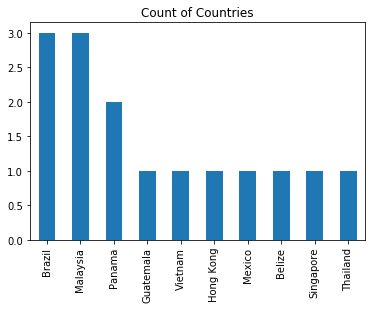

In [33]:
df['country'].value_counts().plot.bar(title = 'Count of Countries');

In [34]:
print(f"There are {df['country'].nunique()} unique countries.")
print(f"There are {df['city'].nunique()} unique cities.")

There are 10 unique countries.
There are 573 unique cities.


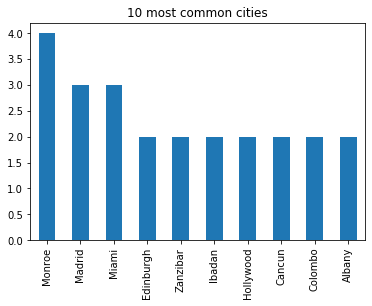

In [35]:
df['city'].value_counts()[:10].plot.bar(title='10 most common cities');

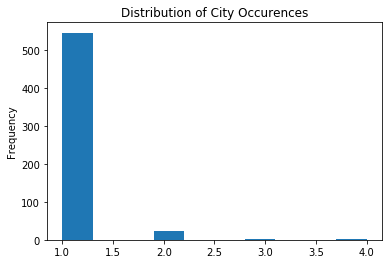

In [36]:
df['city'].value_counts().plot.hist(title='Distribution of City Occurences');

### Accented Names

In [37]:
df['accented_city'] = df['city'].map(city_accent_mapping)
df.loc[df['accented_city']!=df['city']].head()

,headline,country,city,accented_city
6,Geneve Scientists Battle to Find Cure,None,Geneve,Genève
8,Zika Infested Monkeys in Sao Paulo,None,Sao Paulo,São Paulo
16,Louisiana Zika cases up to 26,None,None,NaN
18,Zika infects pregnant woman in Cebu,None,None,NaN
46,18 new Zika Cases in Bogota,None,Bogota,Bogotá


In [38]:
print(gc.get_cities_by_name('São Paulo'))

[{'3448439': {'geonameid': 3448439, 'name': 'São Paulo', 'latitude': -23.5475, 'longitude': -46.63611, 'countrycode': 'BR', 'population': 10021295, 'timezone': 'America/Sao_Paulo', 'admin1code': '27'}}]


### Handling Duplicate Cities

For each city with multiple entries in geonames, we'll choose the city with the greatest population.

In [39]:
gc.get_cities_by_name('Boston')

[{'2655138': {'geonameid': 2655138,
   'name': 'Boston',
   'latitude': 52.97633,
   'longitude': -0.02664,
   'countrycode': 'GB',
   'population': 41340,
   'timezone': 'Europe/London',
   'admin1code': 'ENG'}},
 {'4930956': {'geonameid': 4930956,
   'name': 'Boston',
   'latitude': 42.35843,
   'longitude': -71.05977,
   'countrycode': 'US',
   'population': 667137,
   'timezone': 'America/New_York',
   'admin1code': 'MA'}}]

In [40]:
matches = gc.get_cities_by_name('Boston')
matches = [{k: v for k, v in list(match.values())[0].items()} for match in matches]
matches = sorted(matches, key=lambda x: x["population"], reverse=True)
matches

[{'geonameid': 4930956,
  'name': 'Boston',
  'latitude': 42.35843,
  'longitude': -71.05977,
  'countrycode': 'US',
  'population': 667137,
  'timezone': 'America/New_York',
  'admin1code': 'MA'},
 {'geonameid': 2655138,
  'name': 'Boston',
  'latitude': 52.97633,
  'longitude': -0.02664,
  'countrycode': 'GB',
  'population': 41340,
  'timezone': 'Europe/London',
  'admin1code': 'ENG'}]

### Finding Locations for Cities

In [41]:
city_locations = []

for city in df['accented_city']:
    matches = gc.get_cities_by_name(city)
    if matches:
        matches = [{k: v for k, v in list(match.values())[0].items()} for match in matches]
        matches = sorted(matches, key=lambda x: x['population'], reverse=True)
        match = matches[0]
        
        city_locations.append(
        {
            'name': match['name'],
            'latitude': match['latitude'],
            'longitude': match['longitude'],
            'countrycode': match['countrycode'],
            'population': match['population']
        }
    )
    
city_locations[-5:]

[{'name': 'Jerusalem',
  'latitude': 31.76904,
  'longitude': 35.21633,
  'countrycode': 'IL',
  'population': 801000},
 {'name': 'Indang',
  'latitude': 14.19528,
  'longitude': 120.87694,
  'countrycode': 'PH',
  'population': 41159},
 {'name': 'Suva',
  'latitude': -18.14161,
  'longitude': 178.44149,
  'countrycode': 'FJ',
  'population': 77366},
 {'name': 'Bella Vista',
  'latitude': 18.45539,
  'longitude': -69.9454,
  'countrycode': 'DO',
  'population': 175683},
 {'name': 'Wichita Falls',
  'latitude': 33.91371,
  'longitude': -98.49339,
  'countrycode': 'US',
  'population': 104710}]

In [42]:
city_locations = pd.DataFrame(city_locations)
city_locations.drop_duplicates(inplace=True)
print(f"We have the locations for {city_locations['name'].nunique()} unique cities.")

We have the locations for 573 unique cities.


In [43]:
df = pd.merge(
    df, city_locations, left_on="accented_city", right_on="name", how="left"
)
df.head()

,headline,country,city,accented_city,name,latitude,longitude,countrycode,population
0,Could Zika Reach New York City?,None,New York City,New York City,New York City,40.71427,-74.00597,US,8175133.0
1,First Case of Zika in Miami Beach,None,Miami Beach,Miami Beach,Miami Beach,25.79065,-80.13005,US,92312.0
2,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife,Recife,Recife,-8.05389,-34.88111,BR,1478098.0
3,Dallas man comes down with case of Zika,None,Dallas,Dallas,Dallas,32.78306,-96.80667,US,1300092.0
4,Trinidad confirms first Zika case,None,Trinidad,Trinidad,Trinidad,-14.83333,-64.90000,BO,84259.0


In [44]:
df.loc[df['city'] == 'Toronto']

,headline,country,city,accented_city,name,latitude,longitude,countrycode,population
45,More people in Toronto are infected with Hepat...,None,Toronto,Toronto,Toronto,43.70011,-79.4163,CA,2600000.0


In [45]:
df.loc[df['city'] == 'San Jose']

,headline,country,city,accented_city,name,latitude,longitude,countrycode,population
219,Rhinovirus Comes to San Jose,None,San Jose,San Jose,San Jose,37.33939,-121.89496,US,1026908.0
560,Pneumonia Exposure in San Jose,None,San Jose,San Jose,San Jose,37.33939,-121.89496,US,1026908.0


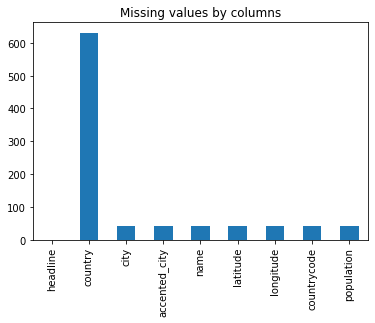

In [46]:
df.isnull().sum().plot.bar(title='Missing values by columns');

In [47]:
df.drop('country', axis=1, inplace=True)

In [48]:
no_name = df[df["name"].isna()].copy()

print(f"There are {len(no_name)} headlines without a city.")

There are 42 headlines without a city.


In [49]:
no_name.head()

,headline,city,accented_city,name,latitude,longitude,countrycode,population
16,Louisiana Zika cases up to 26,None,NaN,NaN,NaN,NaN,NaN,NaN
18,Zika infects pregnant woman in Cebu,None,NaN,NaN,NaN,NaN,NaN,NaN
47,Spanish Flu Sighted in Antigua,None,NaN,NaN,NaN,NaN,NaN,NaN
62,Carnival under threat in Rio De Janeiro due to...,None,NaN,NaN,NaN,NaN,NaN,NaN
72,Zika case reported in Oton,None,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
city_set = set(city_accent_mapping.keys())
for city in ['Louisiana', 'Cebu', 'Antigua','Rio De Janeiro', 'Oton']:
    if city in city_set:
        print('Found', city)
    else:
        print('Did not find city')

Did not find city
Did not find city
Did not find city
Did not find city
Did not find city


It appears that the 42 headlines without a city name may have a city, but it is not included in geonamescache. We'll have to go ahead and remove these cities since they cannot be used.

In [51]:
df = df.dropna(subset=['name'])
df.describe()

,latitude,longitude,population
count,604.000000,604.000000,6.040000e+02
mean,26.767388,-38.173742,8.912155e+05
std,20.636822,79.528355,1.975643e+06
min,-53.787690,-156.506040,1.338100e+04
25%,16.242230,-90.453532,5.869225e+04
50%,33.768395,-76.494395,1.707700e+05
75%,40.719617,7.195388,6.480340e+05
max,59.938630,179.364510,1.307630e+07


In [52]:
print(f"We have the city locations for {len(df)} cities")

We have the city locations for 604 cities


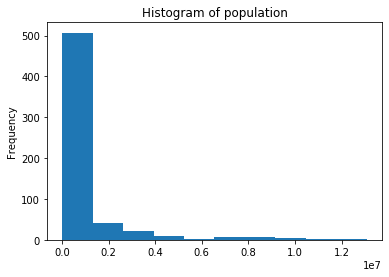

In [53]:
df['population'].plot.hist(title='Histogram of population');

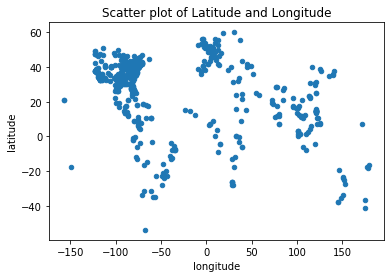

In [54]:
df.plot.scatter(x='longitude', y='latitude', title='Scatter plot of Latitude and Longitude');

In [55]:
df = df[['headline', 'city', 'latitude', 'longitude', 'countrycode']]

In [56]:
df.head()

,headline,city,latitude,longitude,countrycode
0,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US
1,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US
2,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR
3,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US
4,Trinidad confirms first Zika case,Trinidad,-14.83333,-64.90000,BO


In [57]:
df.isnull().sum()

headline       0
city           0
latitude       0
longitude      0
countrycode    0
dtype: int64

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604 entries, 0 to 645
Data columns (total 5 columns):
headline       604 non-null object
city           604 non-null object
latitude       604 non-null float64
longitude      604 non-null float64
countrycode    604 non-null object
dtypes: float64(2), object(3)
memory usage: 28.3+ KB


### Euclidean Distance

In [59]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)
clusterer

DBSCAN()

In [60]:
def cluster_location(clusterer, df, lat_string='latitude', lon_string='longitude'):
    features = df[[lat_string, lon_string]].copy()
    clusterer.fit(features)
    df['cluster'] = clusterer.labels_
    return df

In [61]:
df = cluster_location(clusterer, df)
df['cluster'].value_counts()

-1    476
 4     26
 0     21
 1     18
 6     14
 7     12
 3     12
 5      8
 9      6
 2      6
 8      5
Name: cluster, dtype: int64

In [62]:
clusterer.eps=9
df = cluster_location(clusterer, df)
df['cluster'].value_counts()

 0     370
 2      59
 3      57
-1      32
 1      21
 5      16
 8       9
 4       9
 6       8
 11      7
 9       6
 7       6
 10      4
Name: cluster, dtype: int64

In [63]:
clusterer.min_samples = 3
df = cluster_location(clusterer, df)
df['cluster'].value_counts()

 0     372
 4      62
 2      59
 1      21
-1      16
 8      16
 11      9
 10      9
 5       9
 9       8
 12      6
 7       6
 3       5
 13      3
 6       3
Name: cluster, dtype: int64

In [64]:
best_euclidean_clusterer = DBSCAN(eps=9, min_samples=3, metric='euclidean')
df = cluster_location(best_euclidean_clusterer, df)

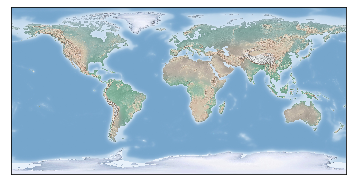

In [65]:
from mpl_toolkits.basemap import Basemap

plt.rcParams['font.size'] = 18
m = Basemap()
m.shadedrelief();

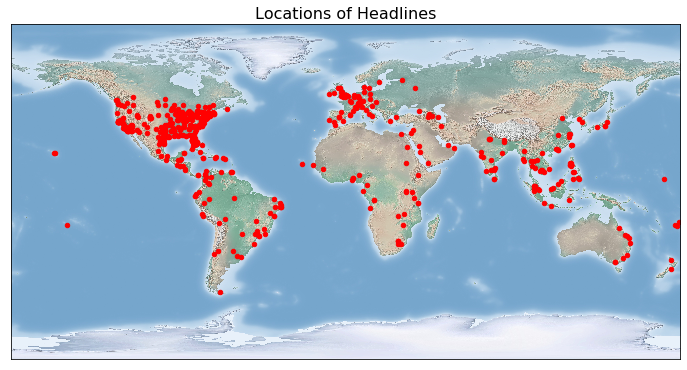

In [66]:
plt.figure(figsize=(12,8))

x, y = m(x = df['longitude'], y = df['latitude'])

m.shadedrelief()

plt.scatter(x, y, 20, marker='o', color='red')
ax = plt.gca()
_ = ax.set_title('Locations of Headlines', size = 16);

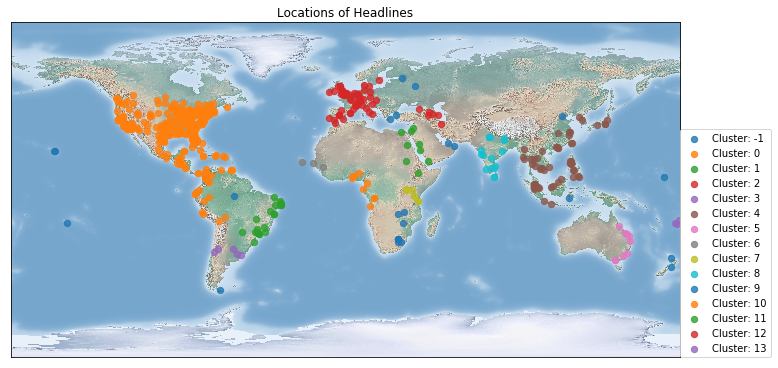

In [67]:
plt.figure(figsize=(12,8))
m.shadedrelief()
df['x'], df['y'] = x, y
for cluster, grouped in df.groupby('cluster'):
    plt.scatter(grouped['x'], grouped['y'], s = 40, alpha = 0.8, marker='o', label=f'Cluster: {cluster}')
ax = plt.gca()
ax.legend(fontsize=10, loc=(1, 0))
ax.set_title('Locations of Headlines', size=12);

In [68]:
def plot_clusters(df):
    plt.figure(figsize=(12,8))
    m.shadedrelief()
    
    for cluster, grouped in df.groupby('cluster'):
        if cluster == -1:
            plt.scatter(grouped['x'], grouped['y'], s = 40, alpha = 0.8, marker = 'o', color = 'k', label = f'Cluster: None')
        else: 
            plt.scatter(grouped['x'], grouped['y'], s = 40, alpha = 0.8, marker = 'o', label = f'Cluster: {cluster}')
    ax = plt.gca()
    ax.legend(fontsize = 10, loc = (1,0))
    ax.set_title('Locations of Headlines', size = 12)

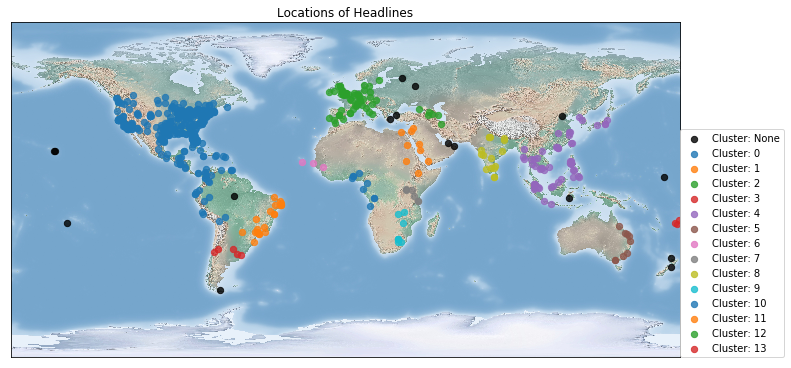

In [69]:
plot_clusters(df);

### Great Circle Distance and the Haversine Formula

In [70]:
def great_circle_distance(coord1, coord2, radius=3956):
    if np.array_equal(coord1, coord2):
        return 0.0
    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    delta_x, delta_y = coord2 - coord1 
    
    haversin = np.sin(delta_x / 2) ** 2 + np.product(
        [np.cos(coord1[0]), np.cos(coord2[0]), np.sin(delta_y / 2) ** 2]
    )
    
    return 2 * radius * np.arcsin(haversin ** 0.5)

In [71]:
df.head()

,headline,city,latitude,longitude,countrycode,cluster,x,y
0,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US,0,-74.00597,40.71427
1,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US,0,-80.13005,25.79065
2,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR,1,-34.88111,-8.05389
3,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US,0,-96.80667,32.78306
4,Trinidad confirms first Zika case,Trinidad,-14.83333,-64.90000,BO,0,-64.90000,-14.83333


In [72]:
coord1 = np.array([
        [df["latitude"].iloc[0], df["latitude"].iloc[1]],
        [df["longitude"].iloc[0], df["longitude"].iloc[1]],
    ])

coord2 = np.array([
        [df["latitude"].iloc[2], df["latitude"].iloc[0]],
        [df["longitude"].iloc[2], df["longitude"].iloc[0]],
    ])
great_circle_distance(coord1, coord2)

array([3368.93208827, 1035.42670669])

### Using Great Circle Distance

In [73]:
great_circle_clusterer = DBSCAN(eps=250, min_samples=4, metric=great_circle_distance)

df = cluster_location(great_circle_clusterer, df, lon_string='longitude', lat_string='latitude')
df['cluster'].value_counts()

 0     237
-1     132
 5      59
 2      49
 4      16
 10     11
 6      11
 8      10
 9       9
 11      8
 16      8
 3       8
 7       7
 1       6
 14      5
 12      4
 20      4
 18      4
 13      4
 15      4
 17      4
 19      4
Name: cluster, dtype: int64

### Great Circle Clustering Map

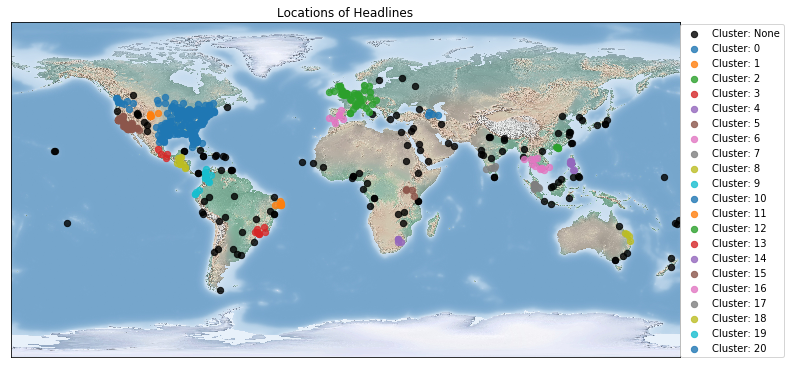

In [74]:
plot_clusters(df);

### Manhattan Distance

In [75]:
manhattan_clusterer = DBSCAN(eps = 9, min_samples = 3, metric = 'manhattan')

df = cluster_location(manhattan_clusterer, df)

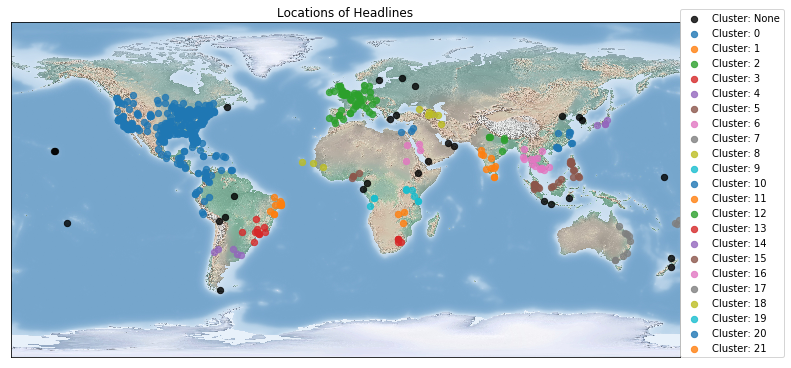

In [76]:
plot_clusters(df);

### KMeans

In [77]:
from sklearn.cluster import KMeans

kmeans_clusterer = KMeans()
kmeans_clusterer

KMeans()

In [78]:
inertia_values = []
for k in range(1, 11):
    inertia_values.append(KMeans(n_clusters = k).fit(df[['longitude', 'latitude']]).inertia_)

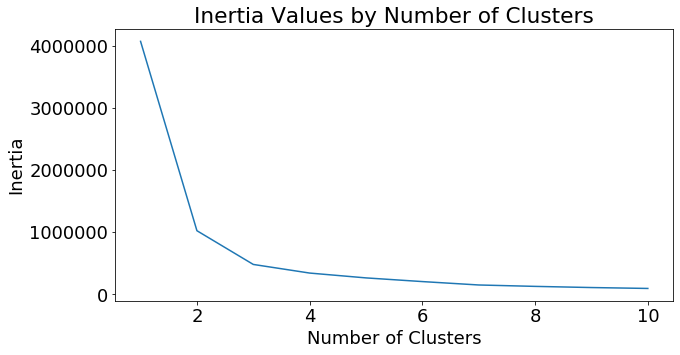

In [79]:
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), inertia_values)
plt.title('Inertia Values by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

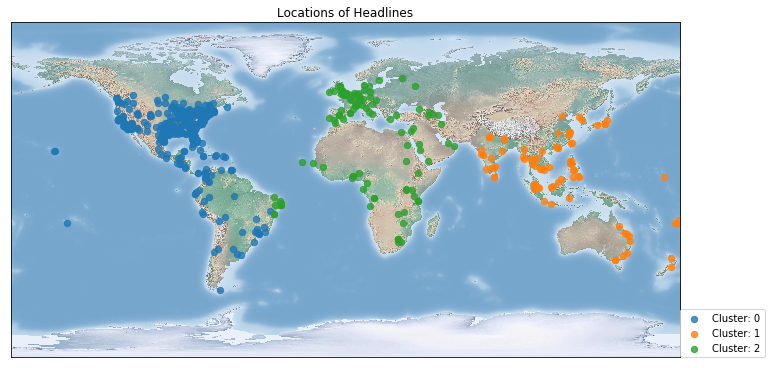

In [80]:
kmeans_clusterer = KMeans(n_clusters=3)
df = cluster_location(kmeans_clusterer, df)
plot_clusters(df);

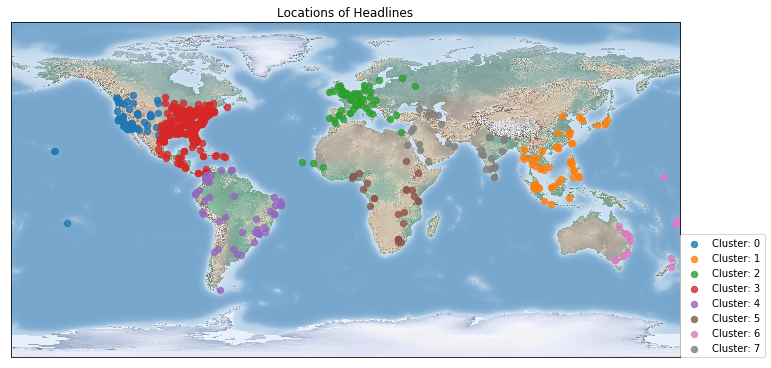

In [81]:
kmeans_clusterer = KMeans(n_clusters=8)
df = cluster_location(kmeans_clusterer, df)
plot_clusters(df);

### World Plot

For the final output of this section, we'll create a plot using the best-identified clusterer (euclidean distance) without the outliers.

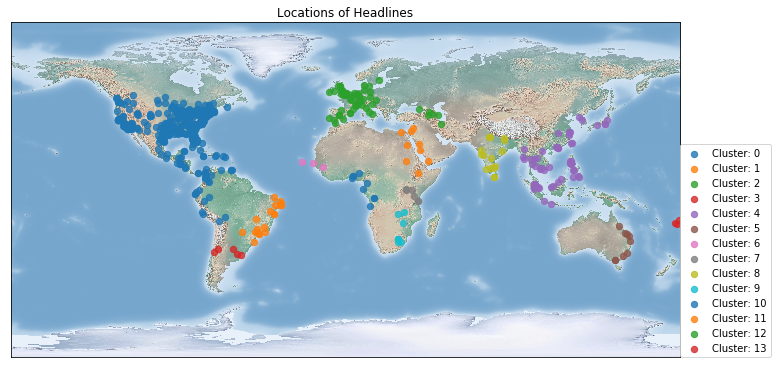

In [82]:
best_clusterer = DBSCAN(eps=9, min_samples=3, metric='euclidean')
df = cluster_location(best_clusterer, df)
plot_clusters(df.loc[df['cluster']!=-1]);

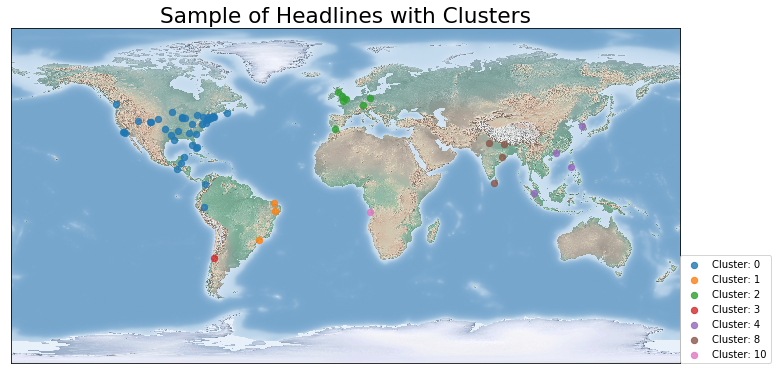

In [83]:
plot_clusters(df.loc[df['cluster']!=-1].sample(frac=0.10))
plt.title('Sample of Headlines with Clusters');

### Clusters Distribution

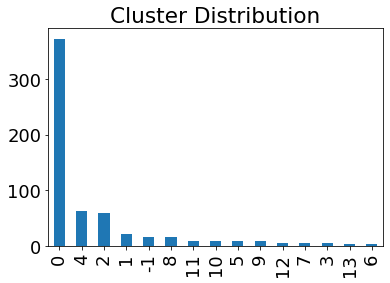

In [84]:
df['cluster'].value_counts().plot.bar(title='Cluster Distribution');

In [85]:
df.groupby('countrycode')['cluster'].value_counts()['US']

cluster
 0    302
-1      2
Name: cluster, dtype: int64

In [86]:
df = df[['headline', 'city', 'latitude', 'longitude', 'countrycode', 'cluster']]

In [87]:
df.head()

,headline,city,latitude,longitude,countrycode,cluster
0,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US,0
1,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US,0
2,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR,1
3,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US,0
4,Trinidad confirms first Zika case,Trinidad,-14.83333,-64.90000,BO,0
